In [1]:
import pandas as pd
import numpy as np
from scipy.stats.mstats import rankdata
from collections import Counter
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from math import sqrt
import seaborn as sns
import matplotlib.pyplot as plt
from label_ranking import *
from rank_aggregation import *

# MeOH dataset

In [2]:
meoh_data = pd.read_csv("datasets/aryl_borylation/data_MeOH_final.csv")
ligands = list(meoh_data["Ligand"].unique())
substrates = list(meoh_data["Electrophile"].unique())

In [3]:
yield_array = np.ones((len(substrates), len(ligands))) * -1

for i, row in meoh_data.iterrows():
    ligand_name = row["Ligand"]
    substrate_name = row["Electrophile"]
    yield_array[substrates.index(substrate_name), ligands.index(ligand_name)]  = row["Yield"]
    
print(f"There are {np.sum(yield_array<0)} missing entries. {np.where(yield_array < 0)}")

yield_array[yield_array < 0] = 0

There are 3 missing entries. (array([ 3,  6, 10]), array([14, 14, 14]))


In [4]:
ranking_array = yield_array.shape[1] - rankdata(yield_array, axis=1) + 1

print(Counter(np.argmin(ranking_array, axis=1)))

Counter({18: 6, 4: 5, 17: 4, 5: 4, 0: 3, 21: 2, 16: 2, 2: 2, 11: 1, 14: 1, 10: 1, 3: 1, 6: 1, 19: 1})


In [6]:
np.argsort(np.mean(yield_array, axis=0))

array([20,  9, 13, 12, 22,  1, 15, 14,  6, 11, 21,  8,  0, 19, 10,  2,  7,
       16,  5,  3, 17, 18,  4])

In [5]:
Counter(np.where(ranking_array == 2)[1])

Counter({3: 5,
         4: 4,
         0: 3,
         17: 3,
         16: 3,
         19: 3,
         18: 2,
         2: 2,
         5: 2,
         13: 2,
         21: 2,
         11: 1})

### Original paper

In [6]:
# External data
indices=[0,12,17]
mapped = map(meoh_data.Electrophile.unique().tolist().__getitem__, indices)
external_list=list(mapped)
print(external_list)

raw_validation_df = meoh_data[meoh_data['Electrophile'].isin(external_list)]
validation_df = raw_validation_df.drop(['Electrophile_inchi', 'Solvent_inchi', 'Ligand_inchi', 'Product_inchi', 'Electrophile', 'Ligand'], axis = 1)
print(validation_df.shape)

['1H-indol-5-yl\xa0N,N-dimethylsulfamate', 'Ethyl\xa04-chloro-3-fluorobenzoate', 'Clofibrate']
(69, 157)


In [7]:
# Training data
exclude_list = validation_df.index.values.tolist()
raw_train_df = meoh_data[~meoh_data.index.isin(exclude_list)]
train_df = raw_train_df.drop(['Electrophile_inchi', 'Solvent_inchi', 'Ligand_inchi', 'Product_inchi', 'Electrophile', 'Ligand'], axis = 1)
print(train_df.shape)

(710, 157)


In [8]:
X_train=train_df.drop(columns=['Yield'])
Y_train=train_df['Yield']

In [9]:
# Best for the MeOH dataset
rfr = RandomForestRegressor(
    n_estimators=610,
    min_samples_split=15,
    min_samples_leaf=1,
    max_features="log2",
    max_depth=10,
    random_state=np.random.RandomState(0)
)

rfr.fit(X_train, Y_train)

X_test = validation_df.iloc[:, validation_df.columns.isin(X_train.columns)]
y_test = validation_df["Yield"]

y_pred = rfr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(round(sqrt(mse), 1))

21.7


In [10]:
predicted_yield_array = np.zeros((3,23))
actual_yield_array = np.zeros((3,23))
rowcount = 0
for i, row in raw_validation_df.iterrows() :
    elec = row["Electrophile"]
    ligand = row["Ligand"]
    predicted_yield_array[external_list.index(elec), ligands.index(ligand)] = y_pred[rowcount]
    actual_yield_array[external_list.index(elec), ligands.index(ligand)]  = row["Yield"]
    rowcount += 1

rfr_predicted_rank_array = predicted_yield_array.shape[1] - rankdata(predicted_yield_array, axis=1) + 1
actual_rank_array = actual_yield_array.shape[1] - rankdata(actual_yield_array, axis=1) + 1

In [11]:
### Predicted ranks
actual_rank_array[np.where(rfr_predicted_rank_array <= 5)].reshape((3,5))

array([[ 8.,  3.,  4.,  1., 18.],
       [18.,  5.,  3.,  4.,  8.],
       [ 2.,  1.,  3.,  6.,  4.]])

In [12]:
np.sort(actual_yield_array)[::-1]

array([[ 2.52 ,  9.94 , 18.25 , 19.73 , 20.03 , 22.11 , 24.63 , 29.38 ,
        29.82 , 30.27 , 30.27 , 34.12 , 36.65 , 38.87 , 39.17 , 39.32 ,
        40.8  , 52.08 , 52.52 , 60.24 , 75.67 , 93.32 , 93.47 ],
       [13.88 , 16.775, 16.775, 16.825, 20.29 , 20.675, 23.05 , 24.66 ,
        25.86 , 29.795, 30.11 , 34.075, 37.63 , 39.195, 43.93 , 47.53 ,
        50.27 , 54.325, 55.48 , 55.91 , 59.92 , 61.91 , 64.245],
       [ 0.   ,  0.82 ,  5.66 ,  6.73 , 12.16 , 17.72 , 18.23 , 19.74 ,
        30.4  , 42.08 , 53.73 , 54.07 , 57.87 , 74.99 , 76.65 , 80.25 ,
        81.79 , 81.83 , 82.92 , 87.76 , 88.21 , 88.86 , 89.66 ]])

### RPC

In [13]:
train_electrophiles = list(raw_train_df["Electrophile"].unique())
y_rank_train = np.zeros((len(train_electrophiles), len(ligands)))
X_rank_train = np.zeros((len(train_electrophiles), 26))

for i, row in raw_train_df.iterrows():
    y_rank_train[train_electrophiles.index(row["Electrophile"]), ligands.index(row["Ligand"])] = row["Yield"]
    X_rank_train[train_electrophiles.index(row["Electrophile"])] = row.iloc[:26]
y_rank_train = y_rank_train.shape[1] - rankdata(y_rank_train, axis=1) + 1

from sklearn.metrics import make_scorer

def kendall_tau(y_true, y_pred):
    kt = kendalltau(y_true, y_pred).statistic
    return kt
kt_score = make_scorer(kendall_tau, greater_is_better=True)

rpc_gcv = GridSearchCV(
    RPC(),
    param_grid={"n_estimators":[50,100,200], "max_depth":[2,5,10]},
    n_jobs = -1,
    scoring=kt_score,
    cv=5
)
rpc_gcv.fit(X_rank_train, y_rank_train)

GridSearchCV(cv=5, estimator=RPC(), n_jobs=-1,
             param_grid={'max_depth': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring=make_scorer(kendall_tau))

In [14]:
y_rank_test = np.zeros((3, len(ligands)))
X_rank_test = np.zeros((3, 26))

for i, row in raw_validation_df.iterrows():
    y_rank_test[external_list.index(row["Electrophile"]), ligands.index(row["Ligand"])] = row["Yield"]
    X_rank_test[external_list.index(row["Electrophile"])] = row.iloc[:26]
y_rank_test = y_rank_test.shape[1] - rankdata(y_rank_test, axis=1) + 1
rpc_predicted_rank_array = rpc_gcv.predict(X_rank_test)
print(rpc_predicted_rank_array)

[[ 5 18 12 15  3 16  9 13 11 14 10 17 22 21  2 19  4  6  1  7 23  8 20]
 [ 8 20  6 11  7 13 10 18 15 16  9 12 17 22 14 19  3  4  1  2 23  5 21]
 [14 15  6  2  1  4 19  5  8 22 10 11 20 21 13 16  9  7  3 12 23 18 17]]


In [15]:
### Predicted ranks
actual_rank_array[np.where(rpc_predicted_rank_array <= 5)].reshape((3,5))

array([[ 2.,  8., 11.,  3.,  1.],
       [ 1.,  3.,  4.,  8.,  7.],
       [ 2.,  1.,  3.,  6.,  4.]])

## LRRF

In [16]:
lrrf_gcv = GridSearchCV(
    LabelRankingRandomForest(),
    param_grid={"n_estimators":[50,100,200], "max_depth":[2,5,10]},
    n_jobs = -1,
    scoring=kt_score,
    cv=5
)
lrrf_gcv.fit(X_rank_train, y_rank_train)

GridSearchCV(cv=5, estimator=LabelRankingRandomForest(), n_jobs=-1,
             param_grid={'max_depth': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring=make_scorer(kendall_tau))

In [17]:
lrrf_predicted_rank_array = lrrf_gcv.predict(X_rank_test)

actual_rank_array[np.where(lrrf_predicted_rank_array <= 5)].reshape((3,5))

array([[2., 8., 3., 4., 1.],
       [6., 5., 1., 3., 4.],
       [2., 1., 3., 6., 4.]])

# EtOH dataset

In [18]:
etoh_data = pd.read_csv("datasets/aryl_borylation/data_EtOH_final.csv")
ligands = list(etoh_data["Ligand"].unique())
substrates = list(etoh_data["Electrophile"].unique())

# yield_array = np.ones((len(substrates), len(ligands))) * -1

# for i, row in etoh_data.iterrows():
#     ligand_name = row["Ligand"]
#     substrate_name = row["Electrophile"]
#     yield_array[substrates.index(substrate_name), ligands.index(ligand_name)]  = row["Yield"]
    
# print(f"There are {np.sum(yield_array<0)} missing entries.")

# yield_array[yield_array < 0] = 0

etoh_raw_validation_df = etoh_data[etoh_data['Electrophile'].isin(external_list)]
etoh_validation_df = etoh_raw_validation_df.drop(['Electrophile_inchi', 'Solvent_inchi', 'Ligand_inchi', 'Product_inchi', 'Electrophile', 'Ligand'], axis = 1)

# Training data
etoh_raw_train_df = etoh_data[~etoh_data.index.isin(exclude_list)]
etoh_train_df = etoh_raw_train_df.drop(['Electrophile_inchi', 'Solvent_inchi', 'Ligand_inchi', 'Product_inchi', 'Electrophile', 'Ligand'], axis = 1)
print(etoh_train_df.shape)

X_etoh_train=etoh_train_df.drop(columns=['Yield'])
Y_etoh_train=etoh_train_df['Yield']

(710, 157)


In [19]:
# Best for the EtOH dataset
rfr = RandomForestRegressor(
    n_estimators=1986,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features="log2",
    max_depth=160,
    random_state=np.random.RandomState(0),
    bootstrap=False
)

rfr.fit(X_etoh_train, Y_etoh_train)

X_etoh_test = etoh_validation_df.iloc[:, etoh_validation_df.columns.isin(X_etoh_train.columns)]
y_etoh_test = etoh_validation_df["Yield"]

y_etoh_pred = rfr.predict(X_etoh_test)
mse = mean_squared_error(y_etoh_test, y_etoh_pred)
print(round(sqrt(mse), 1))

19.1


In [20]:
predicted_yield_array = np.zeros((3,23))
actual_yield_array = np.zeros((3,23))
rowcount = 0
for i, row in etoh_raw_validation_df.iterrows() :
    elec = row["Electrophile"]
    ligand = row["Ligand"]
    predicted_yield_array[external_list.index(elec), ligands.index(ligand)] = y_etoh_pred[rowcount]
    actual_yield_array[external_list.index(elec), ligands.index(ligand)]  = row["Yield"]
    rowcount += 1

etoh_rfr_predicted_rank_array = predicted_yield_array.shape[1] - rankdata(predicted_yield_array, axis=1) + 1
actual_rank_array = actual_yield_array.shape[1] - rankdata(actual_yield_array, axis=1) + 1

### Predicted ranks
for i in range(1,6) :
    print(actual_rank_array[np.where(etoh_rfr_predicted_rank_array <= i)].reshape((3,i)))
    print()

[[ 3.]
 [10.]
 [ 1.]]

[[ 4.  3.]
 [ 5. 10.]
 [ 1.  3.]]

[[ 4.  3.  2.]
 [ 6.  5. 10.]
 [ 1.  8.  3.]]

[[ 4.  3.  7.  2.]
 [ 3.  6.  5. 10.]
 [ 1. 10.  8.  3.]]

[[ 4.  3.  7.  2.  6.]
 [ 3.  6.  5. 10.  9.]
 [ 1.  4. 10.  8.  3.]]



In [21]:
np.sort(actual_yield_array)[::-1]

array([[ 1.48 ,  5.19 ,  7.12 , 10.68 , 23.29 , 27.3  , 32.94 , 38.13 ,
        38.43 , 39.17 , 43.77 , 46.29 , 46.59 , 53.71 , 56.83 , 61.72 ,
        62.02 , 69.88 , 72.26 , 75.07 , 76.85 , 82.64 , 95.25 ],
       [11.91 , 13.45 , 13.495, 14.285, 16.3  , 17.07 , 18.635, 19.02 ,
        20.605, 24.14 , 24.545, 25.31 , 27.28 , 29.32 , 29.705, 30.835,
        30.88 , 34.55 , 36.16 , 37.61 , 38.38 , 43.61 , 43.995],
       [ 0.   ,  0.   ,  2.31 ,  3.73 ,  6.37 , 11.34 , 16.8  , 53.8  ,
        56.11 , 64.52 , 68.95 , 69.3  , 71.75 , 72.88 , 80.44 , 83.28 ,
        85.3  , 85.47 , 86.96 , 87.13 , 87.97 , 88.21 , 88.35 ]])

## RPC

In [22]:
etoh_train_electrophiles = list(etoh_raw_train_df["Electrophile"].unique())
y_rank_etoh_train = np.zeros((len(etoh_train_electrophiles), len(ligands)))
X_rank_etoh_train = np.zeros((len(etoh_train_electrophiles), 26))

for i, row in etoh_raw_train_df.iterrows():
    y_rank_etoh_train[etoh_train_electrophiles.index(row["Electrophile"]), ligands.index(row["Ligand"])] = row["Yield"]
    X_rank_etoh_train[etoh_train_electrophiles.index(row["Electrophile"])] = row.iloc[:26]
y_rank_etoh_train = y_rank_etoh_train.shape[1] - rankdata(y_rank_etoh_train, axis=1) + 1

rpc_gcv = GridSearchCV(
    RPC(),
    param_grid={"n_estimators":[50,100,200], "max_depth":[2,5,10]},
    n_jobs = -1,
    scoring=kt_score,
    cv=5
)
rpc_gcv.fit(X_rank_etoh_train, y_rank_etoh_train)

GridSearchCV(cv=5, estimator=RPC(), n_jobs=-1,
             param_grid={'max_depth': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring=make_scorer(kendall_tau))

In [23]:
y_rank_etoh_test = np.zeros((3, len(ligands)))
X_rank_etoh_test = np.zeros((3, 26))

for i, row in etoh_raw_validation_df.iterrows():
    y_rank_etoh_test[external_list.index(row["Electrophile"]), ligands.index(row["Ligand"])] = row["Yield"]
    X_rank_etoh_test[external_list.index(row["Electrophile"])] = row.iloc[:26]
y_rank_etoh_test = y_rank_etoh_test.shape[1] - rankdata(y_rank_etoh_test, axis=1) + 1
etoh_rpc_predicted_rank_array = rpc_gcv.predict(X_rank_etoh_test)
# print(y_rank_pred)

### Predicted ranks
for i in range(1,6):
    print(actual_rank_array[np.where(etoh_rpc_predicted_rank_array <= i)].reshape((3,i)))
    print()

[[ 3.]
 [10.]
 [ 3.]]

[[ 4.  3.]
 [ 5. 10.]
 [ 1.  3.]]

[[ 4.  3.  7.]
 [ 5. 10.  9.]
 [ 1. 10.  3.]]

[[ 4.  9.  3.  7.]
 [ 5.  2. 10.  9.]
 [ 1. 10.  8.  3.]]

[[ 4.  9.  3.  7.  2.]
 [ 3.  5.  2. 10.  9.]
 [ 1.  4. 10.  8.  3.]]



## LRRF

In [24]:
lrrf_gcv = GridSearchCV(
    LabelRankingRandomForest(),
    param_grid={"n_estimators":[50,100,200], "max_depth":[2,5,10]},
    n_jobs = -1,
    scoring=kt_score,
    cv=5
)
lrrf_gcv.fit(X_rank_etoh_train, y_rank_etoh_train)

GridSearchCV(cv=5, estimator=LabelRankingRandomForest(), n_jobs=-1,
             param_grid={'max_depth': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring=make_scorer(kendall_tau))

In [25]:
etoh_lrrf_predicted_rank_array = lrrf_gcv.predict(X_rank_etoh_test)

for i in range(1,6):
    print(actual_rank_array[np.where(etoh_lrrf_predicted_rank_array <= i)].reshape((3,i)))
    print()

[[ 2.]
 [10.]
 [ 1.]]

[[ 3.  2.]
 [ 5. 10.]
 [ 1.  3.]]

[[ 4.  3.  2.]
 [ 3.  5. 10.]
 [ 1. 10.  3.]]

[[ 4.  3.  7.  2.]
 [ 3.  5.  2. 10.]
 [ 1. 10.  8.  3.]]

[[ 4.  9.  3.  7.  2.]
 [ 3.  6.  5.  2. 10.]
 [ 1. 10.  8.  3. 11.]]



# Plotting altogether

Text(0.5, 0.01, 'Number of Experiments Conducted')

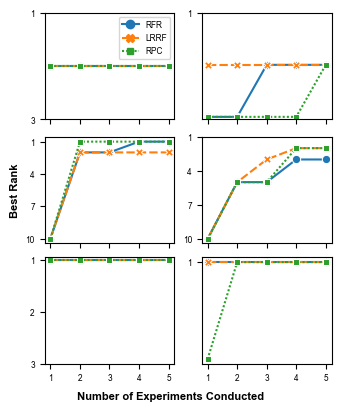

In [34]:
# Goes in the SI
from itertools import product
pred_rank_arrays = [
    [rfr_predicted_rank_array, lrrf_predicted_rank_array, rpc_predicted_rank_array],
    [etoh_rfr_predicted_rank_array, etoh_lrrf_predicted_rank_array, etoh_rpc_predicted_rank_array]
]
models = ["RFR", "LRRF", "RPC"]
dict_to_plot = {
    "Number of Experiments Conducted":[],
    "Actual Rank of Best Experiment":[],
    "Model":[],
    "Compound":[]
}
dicts_to_plot = [dict_to_plot, deepcopy(dict_to_plot)]

for a in range(2) :
    for pred_array, model in zip(pred_rank_arrays[a], models):
        for i in range(5) :
            dicts_to_plot[a]["Actual Rank of Best Experiment"].extend(
                list(np.min(actual_rank_array[np.where(pred_array <= i+1)].reshape((3,i+1)), axis=1).flatten())
            )
            dicts_to_plot[a]["Compound"].extend([1,2,3])
            dicts_to_plot[a]["Model"].extend([model, model, model])
            dicts_to_plot[a]["Number of Experiments Conducted"].extend([i+1, i+1, i+1])
dfs_to_plot = [pd.DataFrame(x) for x in dicts_to_plot]

fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(3.3, 4), sharex=True, tight_layout=True, layout="constrained")
for i, j in product(range(2), range(3)):
    df = dfs_to_plot[i]
    plot_df = df[df["Compound"]==j+1]
    if i == 0 and j == 0 :
        legend = True
    else :
        legend = False
    f = sns.lineplot(
        plot_df, 
        x="Number of Experiments Conducted", 
        y="Actual Rank of Best Experiment", 
        hue="Model",
        style="Model",
        markers=True,
        ax=ax[j, i],
        legend=legend
    )
    if legend :
        ax[j,i].legend(fontsize=6, prop={"size":6, "family":"arial"})
    f.invert_yaxis()
    ax[j, i].set_xlabel("")
    ax[j, i].set_xticks(np.arange(1,6))
    if j!=1 or (j==1 and i==1):
        ax[j, i].set_ylabel("")
    else : 
        ax[j, i].set_ylabel("Best Rank", fontdict={"fontfamily":"arial", "size":8, "weight":"bold"})
    if j == 0 :
        if i == 0:
            ax[j, i].set_yticks([3,1])
            ax[j, i].set_yticklabels([3,1], fontdict={"fontfamily":"arial", "size":6})
        elif i == 1 :
            ax[j, i].set_yticks([1])
            ax[j, i].set_yticklabels([1], fontdict={"fontfamily":"arial", "size":6})
    elif j == 1 :
        ax[j, i].set_yticks([1,4,7,10])
        ax[j, i].set_yticklabels([1,4,7,10], fontdict={"fontfamily":"arial", "size":6})
    elif j == 2 :
        ax[j,i] .set_xticklabels(np.arange(1,6), fontdict={"fontfamily":"arial", "size":6})
        if i == 1:
            ax[j, i].set_yticks([1])
            ax[j, i].set_yticklabels([1], fontdict={"fontfamily":"arial", "size":6})
        else :
            ax[j, i].set_yticks([1,2,3])
            ax[j, i].set_yticklabels([1,2,3], fontdict={"fontfamily":"arial", "size":6})
    

fig.supxlabel("Number of Experiments Conducted", size=8, weight="bold", fontdict={"fontfamily":"arial"})

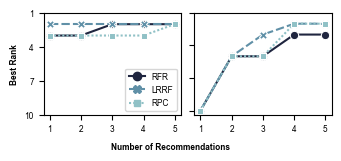

In [35]:
solvents = ["MeOH", "EtOH"]
pal = [x for i, x in enumerate(sns.cubehelix_palette(4, rot=-.25, light=.7)[::-1]) if i in [0,2,3]]

fig, ax = plt.subplots(ncols=2, figsize=(3.3, 1.5), tight_layout=True, layout="constrained")
for i in range(2):
    df = dfs_to_plot[1]
    plot_df = df[df["Compound"]==i+1]
    if i == 0 :
        legend = True
    else :
        legend = False
    f = sns.lineplot(
        plot_df, 
        x="Number of Experiments Conducted", 
        y="Actual Rank of Best Experiment", 
        hue="Model",
        style="Model",
        markers=True,
        ax=ax[i],
        legend=legend,
        palette=pal
    )
    f.invert_yaxis()
    if legend :
        ax[i].legend(fontsize=6, prop={"size":6, "family":"arial"}, loc="lower right")
    ax[i].set_xlabel("")
    ax[i].set_xticks(np.arange(1,6))
    ax[i].set_xticklabels(np.arange(1,6), fontdict={"fontfamily":"arial", "size":6})
    ax[i].set_yticks([1,4,7,10])
    # ax[i].set_title(solvents[i], fontdict={"fontfamily":"arial", "size":6, "fontweight":"bold"})
    if i==1:
        ax[i].set_ylabel("")
        ax[i].set_yticklabels(["" for x in range(4)])
    else : 
        ax[i].set_ylabel("Best Rank", fontdict={"fontfamily":"arial", "size":6, "weight":"bold"})
        ax[i].set_yticklabels([1,4,7,10], fontdict={"fontfamily":"arial", "size":6})

fig.supxlabel("Number of Recommendations", size=6, weight="bold", fontdict={"fontfamily":"arial"})
plt.savefig(f"figures/Figure6B.svg", dpi=300, format="svg")